In [5]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image, make_grid

from torchviz import make_dot

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import glob
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import imageio
from PIL import Image, ImageDraw, ImageFont
import string

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
device

device(type='cuda')

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        
           
        #reduce to features
        self.c0 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
      
        
        #upsample to image
        
        self.d3 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.d2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)
        self.d1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.d0 = nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1)
       
        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)
        

      
        self.bnd3 = nn.BatchNorm2d(256)
        self.bnd2 = nn.BatchNorm2d(128)
        self.bnd1 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):           
                
        en0 = self.c0(x)
        en1 = self.bnc1(self.c1(F.leaky_relu(en0, negative_slope=0.2)))
        en2 = self.bnc2(self.c2(F.leaky_relu(en1, negative_slope=0.2)))
        en3 = self.bnc3(self.c3(F.leaky_relu(en2, negative_slope=0.2)))
        
        de3 = self.bnd3(self.d3(F.relu(en3)))
        de2 = F.dropout(self.bnd2(self.d2(F.relu(torch.cat((en2, de3),1)))))
        de1 = self.bnd1(self.d1(F.relu(torch.cat((en1, de2),1))))

        de0 = torch.tanh(self.d0(F.relu(torch.cat((en0, de1),1))))

        return de0


In [9]:
G = Generator(1,1).to(device)
G.load_state_dict(torch.load('./trained_shader_state_dictionary.pth'))
G.eval()

Generator(
  (c0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d2): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnc1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnc3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnd3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [10]:
'''
The current format of the registration index consists of 4 parts, They are:

    The first two letters indicate the State or Union Territory to which the vehicle is registered.
    The next two digit numbers are the sequential number of a district. Due to heavy volume of vehicle registration, the numbers were given to the RTO offices of registration as well.
    The third part consists of one, two or three letters or no letters at all. This shows the ongoing series of an RTO (Also as a counter of the number of vehicles registered) and/or vehicle classification
    The fourth part is a number from 1 to 9999, unique to each plate. A letter is prefixed when the 4 digit number runs out and then two letters and so on.


'''

'\nThe current format of the registration index consists of 4 parts, They are:\n\n    The first two letters indicate the State or Union Territory to which the vehicle is registered.\n    The next two digit numbers are the sequential number of a district. Due to heavy volume of vehicle registration, the numbers were given to the RTO offices of registration as well.\n    The third part consists of one, two or three letters or no letters at all. This shows the ongoing series of an RTO (Also as a counter of the number of vehicles registered) and/or vehicle classification\n    The fourth part is a number from 1 to 9999, unique to each plate. A letter is prefixed when the 4 digit number runs out and then two letters and so on.\n\n\n'

In [7]:
### https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_India#Unique_numbering
#string gen

STATE_CODES = ['AP', 'AR', 'AS', 'BR', 'CG', 'GA', 'GJ', 'HR', 'HP', 'JH', 'KA', 'KL', 'MP',
              'MH', 'MN', 'ML', 'MZ', 'NL', 'OD', 'PB', 'RJ', 'SK', 'TN', 'TS', 'TR', 'UP',
              'UK', 'WB', 'AN', 'CH', 'DD', 'DL', 'JK', 'LA', 'LD', 'PY', 'OR', 'UA']

SECOND_CODE_MODES = [2, 0, 'S', 'C', 'E', 'P', 'R', 'T', 'V', 'Y'] #not using for now
Letters = ['', 'Q','W','E']

sc = np.random.choice(list(string.ascii_uppercase)) + np.random.choice(list(string.ascii_uppercase))

#font spec lookup (try to find on the fly?)

lp_str = np.random.choice(STATE_CODES) + " " + f"{np.random.randint(100):02}" + " " + sc + " " + f"{np.random.randint(10000):04}"
print(lp_str)

HR 28 OB 9860


In [8]:
image = Image.new('RGB', (128, 32), color = (0,)*3)
draw = ImageDraw.Draw(image)

font_size = 2
font_path = np.random.choice(glob.glob('./fonts/*.ttf'))
font = ImageFont.truetype(font_path, font_size)
while(font.getsize(lp_str)[0]/2 < 57 and font.getsize(lp_str)[1]/2 < 8): 
    font_size+=2
    font = ImageFont.truetype(font_path, font_size)
    print(font.getsize(lp_str)[0]/2)
    

draw.text((64 - font.getsize(lp_str)[0]/2, 16 - font.getsize(lp_str)[1]/2), lp_str, color=(255,)*3, font = font)
image.save('image.png')
image = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)
image.shape


11.5
12.0
18.0
23.0
28.0
29.5
34.5
39.5
46.0


(32, 128)

In [9]:
y = image
#y = cv2.bitwise_not(y)

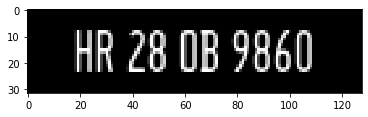

In [10]:
plt.imshow(y, cmap = "gray")



In [11]:
y = y.astype(np.float32)
y = (y - 127.5)/127.5

In [12]:
y = torch.tensor(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)
print(y.shape)

out = G(y)
out = out.squeeze(0).squeeze(0)
out.shape
out = cv2.blur((((out.detach().cpu().numpy() + 1)/2)*255).astype(np.uint8), (3,3))

torch.Size([1, 1, 32, 128])


In [13]:
y=out
random_jitter_matrix = np.array(([1.0 - np.random.uniform(0,0.1), 0, 0], [0, 1.0- np.random.uniform(0,0.1), 0], [0,0,1.0 - np.random.uniform(0,0.1)]))
y = cv2.warpPerspective(y, random_jitter_matrix, dsize = (128, 32), borderValue = np.ones(3)*0)
y = cv2.warpAffine(y, cv2.getRotationMatrix2D((16,64), np.random.uniform(-2, 2), 1), dsize=(128, 32))
y = y+np.random.randint(10)


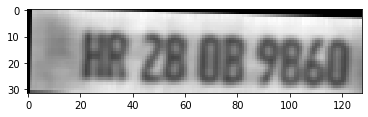

In [14]:
plt.imshow(y, cmap="gray")

In [15]:
imageio.imsave(lp_str+'.png', y)

In [15]:
def make_plate_images(num, shader_path = './trained_shader_state_dictionary.pth', fonts_folder_path = './fonts'):
    
    
    try:
        os.mkdir('./generated_images')
    except Exception as e:
        print(e)
        
    #clearing image folder
    files = glob.glob('./generated_images/*')
    for file in files:
        os.remove(file)
    
    STATE_CODES = [['AP',39], ['AR',22], ['AS', 30], ['BR',57], ['CG',30], ['GA',12], ['GJ',38], ['HR',99], ['HP', 97], ['JH',24], ['KA',70], ['KL',86], ['MP',74],
              ['MH',50], ['MN',7], ['ML',10], ['MZ',8], ['NL',8], ['OD',35], ['PB',91], ['RJ',55], ['SK',4], ['TN',99], ['TS',36], ['TR',8], ['UP',96],
              ['UK',20], ['WB',99], ['AN', 1], ['CH',4], ['DD', 3], ['DL',16], ['JK',22], ['LA',2], ['LD',9], ['PY',5]]
    
    

    #SECOND_CODE_MODES = [2, 0, 'S', 'C', 'E', 'P', 'R', 'T', 'V', 'Y'] #not using for now
    
    for i in tqdm(range(num)):
        
        letters = np.random.choice(list(string.ascii_uppercase)) + np.random.choice(list(string.ascii_uppercase))
        
        state = STATE_CODES[np.random.randint(len(STATE_CODES))]
        

        lp_str = state[0] + " " + f"{state[1]+1:02}" + " " + letters + " " + f"{np.random.randint(10000):04}"

        
        
        image = Image.new('RGB', (128, 32), color = (0,)*3)
        draw = ImageDraw.Draw(image)      
        
        
        font_size = 2
        font_path = np.random.choice(glob.glob('./fonts/*.ttf'))
        font = ImageFont.truetype(font_path, font_size)
        while(font.getsize(lp_str)[0]/2 < 57 and font.getsize(lp_str)[1]/2 < 8): 
            font_size+=2
            font = ImageFont.truetype(font_path, font_size)


        draw.text((64 - font.getsize(lp_str)[0]/2, 16 - font.getsize(lp_str)[1]/2), lp_str, color=(255,)*3, font = font)
        image.save('image.png')
        image = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)

        y = image
        y = y.astype(np.float32)
        y = (y - 127.5)/127.5
        y = torch.tensor(y).to(device)
        y = y.unsqueeze(0).unsqueeze(0)

        out = G(y)
        
        out = out.squeeze(0).squeeze(0)
        out.shape
        out = cv2.blur((((out.detach().cpu().numpy() + 1)/2)*255).astype(np.uint8), (3,3))
        y=out
        random_jitter_matrix = np.array(([1.0 - np.random.uniform(0,0.1), 0, 0], [0, 1.0- np.random.uniform(0,0.1), 0], [0,0,1.0 - np.random.uniform(0,0.1)]))
        y = cv2.warpPerspective(y, random_jitter_matrix, dsize = (128, 32), borderValue = np.ones(3)*0)
        y = cv2.warpAffine(y, cv2.getRotationMatrix2D((16,64), np.random.uniform(-2, 2), 1), dsize=(128, 32))       
        
        
        
        imageio.imsave('./generated_images/' + lp_str +f"__{i}"+ '.png', y)

In [16]:
make_plate_images(10)

[WinError 183] Cannot create a file when that file already exists: './generated_images'


In [17]:
#Creating a GIF

images = []
j = 0
for i in glob.glob("./generated_images/*"):    
    img = imageio.imread(i)
    images.append(img)
    j+=1
    if(j>24):
        break
    

imageio.mimwrite("samplels.gif", images, fps = 5, loop = 0)    